# Sentiment Analysis


# 1 - Data Preprocessing

## 1.1. Download Dataset

In [1]:
# Code to download file into Colaboratory:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

id = '1lTD6bgRkmwguGAr30v-r0KBPdtnVneLb'
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('testing_data.pkl')  

id = '1pCUdlZMoj99UZHtqFeza86fvVQfFmDFX'
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('training_data.pkl')  

import pickle
training_data = pickle.load(open("training_data.pkl","rb"))
testing_data = pickle.load(open("testing_data.pkl","rb"))

print("------------------------------------")
print("Size of training dataset: {0}".format(len(training_data)))
print("Size of testing dataset: {0}".format(len(testing_data)))
print("------------------------------------")

print("------------------------------------")
print("Sample Data")
print("LABEL: {0} / SENTENCE: {1}".format(training_data[1][0], training_data[1][1]))
print("------------------------------------")


------------------------------------
Size of training dataset: 8000
Size of testing dataset: 2000
------------------------------------
------------------------------------
Sample Data
LABEL: neg / SENTENCE: Everything in the kids section of IKEA is so cute. Shame I'm nearly 19 in 2 months :(
------------------------------------


## 1.2. Preprocess data



*For data preprocessing, in order to ensure that the order of the data does not affect the results of the sentiment analysis experiment, I first randomized the experimental data and separated the text and tags in the data. Then process the label, convert'neg' to 0, and'pos' to 1 and store.*

*For the preprocessing of text data, because the project is a sentiment analysis experiment, some irrelevant punctuation marks and numbers need to be removed, because these symbols do not represent a certain emotion. But for expressions like ':)', they represent a certain emotion, such as happiness or sadness, so I converted these symbols into corresponding text, and for emoji, I also converted it into text.*

*Then I processed the text to lowercase. This is to unify all the same words.Whether it is word embedding or RNN network, the text data needs to be segmented, and the entire sentence cannot be used as training data, so it needs to be segmented. After the word segmentation, stop word removal and lemmatization processing are performed. Because it is sentiment analysis, words of different forms basically have the same Emotional meaning, but stop words don’t have much effect.*


In [2]:
 pip install emojiswitch

In [3]:
import numpy as np
from sklearn.preprocessing import LabelEncoder
import re
import nltk
from nltk.tokenize import TweetTokenizer
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords as sw
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
from tqdm import tqdm
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import emojiswitch
import time

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [4]:
training_data = np.array(training_data)
np.random.shuffle(training_data)
np.random.shuffle(testing_data)
#randomized the data

In [5]:
#separated the text and labels in the data
train_data = [data for (_,data) in training_data]
train_label = [label for (label,_) in training_data]
test_data = [data for (_,data) in testing_data]
test_label = [label for (label,_) in testing_data]
labels = ["neg","pos"]

In [6]:
#convert'neg' to 0, and 'pos' to 1
lEnc = LabelEncoder()
lEnc.fit(labels)
train_label_encoded= lEnc.transform(train_label)
test_label_encoded= lEnc.transform(test_label)
print(train_label[:10])
print(train_label_encoded[:10])

['pos', 'neg', 'pos', 'neg', 'pos', 'neg', 'pos', 'pos', 'neg', 'pos']
[1 0 1 0 1 0 1 1 0 1]


In [7]:
puncts = [',', '.', '"', ':', ')', '(', '-', '!', '?', '|', ';', "'", '$', '&', '/', '[', ']', '>', '%', '=', '#', '*', '+', '\\', '•',  '~', '@', '£', 
 '·', '_', '__','{', '}', '©', '^', '®', '`',  '<', '→', '°', '€', '™', '›',  '♥', '←', '×', '§', '″', '′', 'Â', '█', '½', 'à', '…', 
 '“', '★', '”', '–', '●', 'â', '►', '−', '¢', '²', '¬', '░', '¶', '↑', '±', '¿', '▾', '═', '¦', '║', '―', '¥', '▓', '—', '‹', '─', 
 '▒', '：', '¼', '⊕', '▼', '▪', '†', '■', '’', '▀', '¨', '▄', '♫', '☆', 'é', '¯', '♦', '¤', '▲', 'è', '¸', '¾', 'Ã', '⋅', '‘', '∞', 
 '∙', '）', '↓', '、', '│', '（', '»', '，', '♪', '╩', '╚', '³', '・', '╦', '╣', '╔', '╗', '▬', '❤', 'ï', 'Ø', '¹', '≤', '‡', '√']
#removing punctuation
def remove_punctuation(x):
    x = str(x)
    for punct in puncts:
        if punct in x:
            x = x.replace(punct, '')
    return x
#removing numbers and punctuation
def remove_punctuation_re(x):
  
    x = re.sub(r'[^\w\s]','',x)
    x = re.sub(r'[0-9]','',x)

    return x

#converted emoji into text
def emoji_to_word(string):

  new_string = emojiswitch.demojize(string, delimiters=(" ", ""), lang="en")
  
  return new_string

emotions = {
    ':(' : 'sad',
    ':)' : 'happy',
    ':-(' : 'sad',
    ':-)' : 'happy',
    ':P': 'wink and tongue sticking out',
    ':D': 'happy'
}
#converted emotions symbols into text
def emotions_to_word(token_list):
  for i,words in enumerate(token_list):
    if words in emotions:
      token_list[i] = emotions[words]
  return token_list

tknzr = TweetTokenizer()
stop_words = sw.words()
lemmatizer = WordNetLemmatizer()


In [8]:
def sent_preprocessing(sentence):

    sentence = emoji_to_word(sentence)
    sentence = tknzr.tokenize(sentence) 
    sentence = emotions_to_word(sentence)
    sentence = ' '.join(sentence)
    sentence = sentence.lower()
    sentence = remove_punctuation_re(sentence)
    sentence = remove_punctuation(sentence)
    tokens = word_tokenize(sentence) #tokenisation
    filtered_sentence = [w for w in tokens if not w in stop_words] #removing stop words
    text_le = [lemmatizer.lemmatize(w) for w in filtered_sentence] #lemmatization

    return text_le


In [9]:
text_train_le = [sent_preprocessing(s) for s in train_data]
text_test_le = [sent_preprocessing(s) for s in test_data]

# 2 - Model Implementation

## 2.1. Word Embeddings

*For word embedding, I chose the following 3 models for experimentation, namely Word2Vec with CBOW, Word2Vec with SkipGram, FastText with CBOW.*

*Finally, from the result of 3.1, it can be concluded that Word2Vec with SkipGram is better in semantic accuracy.*

*Since this project is sentiment analysis, semantic accuracy is particularly important, so I chose Word2Vec with SkipGram as the word embedding model.*

In [10]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
from lxml import etree 
from nltk.tokenize import word_tokenize, sent_tokenize
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

### 2.1.1. Data Preprocessing for Word Embeddings

*For Word Embedding, because the experimental data set is too small, I merge train_data and test_data and added the TED data set as the Word Embedding data. Since the number of tokens in the data set is still very small, compared to 1.2 data preprocessing,this step does not remove stop words and lemmatization*

In [11]:
id = '1B47OiEiG2Lo1jUY6hy_zMmHBxfKQuJ8-'
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('ted_en-20160408.xml')  
targetXML=open('ted_en-20160408.xml', 'r', encoding='UTF8')

# Getting contents of <content> tag from the xml file
target_text = etree.parse(targetXML)
parse_text = '\n'.join(target_text.xpath('//content/text()'))

In [12]:
# Removing "Sound-effect labels" using regular expression (regex) (i.e. (Audio), (Laughter))
content_text = re.sub(r'\([^)]*\)', '', parse_text)

# Tokenising the sentence to process it by using NLTK library
sent_text=sent_tokenize(content_text)

# Removing punctuation and changing all characters to lower case
normalized_text = []
for string in sent_text:
     tokens = re.sub(r"[^a-z0-9]+", " ", string.lower())
     normalized_text.append(tokens)

# Tokenising each sentence to process individual word
sentences=[]
sentences=[word_tokenize(sentence) for sentence in tqdm(normalized_text)]

100%|██████████| 273424/273424 [00:28<00:00, 9481.69it/s] 


In [13]:
#Define data preprocessing function
def sent_emb_preprocessing(sentence):

    sentence = emoji_to_word(sentence)
    sentence = tknzr.tokenize(sentence) 
    sentence = emotions_to_word(sentence)
    sentence = ' '.join(sentence)
    sentence = sentence.lower()
    sentence = remove_punctuation_re(sentence)
    sentence = remove_punctuation(sentence)
    tokens = word_tokenize(sentence)

    return tokens

In [14]:
text_data = train_data + test_data # merge train_data and test_data 
text_emb_train = [sent_emb_preprocessing(s) for s in tqdm(text_data)]
data_emb = text_emb_train + sentences # merge given data and TED data 

100%|██████████| 10000/10000 [00:05<00:00, 1986.42it/s]


### 2.1.2. Build Word Embeddings Model

*For Word Embedding, because the experimental data set is too small, the model parameter selects min_count=30 to avoid some rare words that affect the accuracy of semantics and Syntactic.Set epcoh = 10 to get good results and avoid overfitting*

*For the Word2Vec with SkipGram model, the window size is set to [2,3,5,7,9] and the word vector dimension is set to [10,20,50,100,200] for comparison experiments.*

*From the 3.1 results, it can be seen that the semantic accuracy of the Word2Vec with Skipgram model is higher, and it is more in line with the requirements of sentiment analysis. The window size is 3 and the word vector dimension of 50 is the best choice.*

In [16]:
# Please comment your code
from gensim.models import Word2Vec
from gensim.models import FastText
from gensim.models.callbacks import CallbackAny2Vec

#Code reference: https://radimrehurek.com/gensim
#Define callbacks function (output W2V loss)
class callback(CallbackAny2Vec):
    """
    Callback to print loss after each epoch
    """
    def __init__(self):
        self.epoch = 0

    def on_epoch_end(self, model):
        loss = model.get_latest_training_loss()
        if self.epoch == 0:
            print('[Training Loss after epoch {}]: {}'.format(self.epoch + 1, loss))
        else:
            print('[Training Loss after epoch {}]: {}'.format(self.epoch + 1, loss- self.loss_previous_step))
        self.epoch += 1
        self.loss_previous_step = loss

In [91]:
def fasttext_training(data_emb, window = 5, size = 100):
    ft_model = FastText(min_count=30, 
                        window = window, 
                        size = size, 
                        seed = 5, 
                        workers=2)
    data_emb = data_emb
    # build vovab
    ft_model.build_vocab(data_emb)
    # train the w2v model
    start = time.perf_counter()
    print("------------------------------------")
    print("Training FastText Embeddings: window size = {} Dim. = {}".format(window, size))
    print('Number of tokens:',ft_model.corpus_count)
    ft_model.train(data_emb, 
                    total_examples=ft_model.corpus_count, 
                    epochs=10)

    elapsed = (time.perf_counter() - start)
    print('Finished Embeddings Training')
    print("------------------------------------")
    print('Running time: %s Seconds'%(elapsed))

    return ft_model
 


In [92]:
def w2v_CBOW_training(data_emb, window = 5, size = 100):    
    w2v_model = Word2Vec(min_count=30, 
                        window=window,
                        sg = 0,  
                        size=size, 
                        seed = 5, 
                        workers=2)
    data_emb = data_emb
    # build vovab
    w2v_model.build_vocab(data_emb)
    # train the w2v model
    start = time.perf_counter()
    print("------------------------------------")
    print("Training CBOW Embeddings: window size = {} Dim. = {}".format(window, size))
    print('Number of tokens:',w2v_model.corpus_count)
    w2v_model.train(data_emb, 
                    total_examples=w2v_model.corpus_count, 
                    epochs=10, 
                    report_delay=1,
                    compute_loss = True, # set compute_loss = True
                    callbacks=[callback()]) # add the callback class

    elapsed = (time.perf_counter() - start)
    print('Finished Embeddings Training')
    print("------------------------------------")
    print('Running time: %s Seconds'%(elapsed))
    return w2v_model
# save the word2vec model


In [93]:
def w2v_SG_training(data_emb,window = 5, size = 100):    
    w2v_model = Word2Vec(min_count=30, 
                        window=window,
                        sg = 1,  
                        size=size,
                        seed = 5, 
                        workers=2)
    data_emb = data_emb
    # build vovab
    w2v_model.build_vocab(data_emb)
    # train the w2v model
    start = time.perf_counter()
    print("------------------------------------")
    print("Training Skip-Gram Embeddings: window size = {} Dim. = {}".format(window, size))
    print('Number of tokens:',w2v_model.corpus_count)
    w2v_model.train(data_emb, 
                    total_examples=w2v_model.corpus_count, 
                    epochs=10, 
                    report_delay=1,
                    compute_loss = True, # set compute_loss = True
                    callbacks=[callback()]) # add the callback class

    elapsed = (time.perf_counter() - start)
    print('Finished Embeddings Training')
    print("------------------------------------")
    print('Running time: %s Seconds'%(elapsed))
    return w2v_model

### 2.1.3. Train Word Embeddings Model

In [90]:
#training fasttext embedding with window = 5, size = 100
ft_5win_100d = fasttext_training(data_emb, window = 5, size = 100)
ft_5win_100d.wv.save_word2vec_format('ft_5win_100d.txt', binary=False)

#training skip_gram embedding with window = 5, size = 100
sg_5win_100d = w2v_SG_training(data_emb, window = 5, size = 100)
sg_5win_100d.wv.save_word2vec_format('sg_5win_100d.txt', binary=False)

#training cbow embedding with window = 5, size = 100
cbow_5win_100d= w2v_CBOW_training(data_emb, window = 5, size = 100)
cbow_5win_100d.wv.save_word2vec_format('cbow_5win_100d.txt', binary=False)

------------------------------------
Training FastText Embeddings: window size = 5 Dim. = 100
Number of tokens: 283424
Finished Embeddings Training
------------------------------------
Running time: 80.95745077999982 Seconds
------------------------------------
Training Skip-Gram Embeddings: window size = 5 Dim. = 100
Number of tokens: 283424
[Training Loss after epoch 1]: 14987708.0
[Training Loss after epoch 2]: 12101336.0
[Training Loss after epoch 3]: 9817452.0
[Training Loss after epoch 4]: 7365008.0
[Training Loss after epoch 5]: 7257608.0
[Training Loss after epoch 6]: 7154356.0
[Training Loss after epoch 7]: 7095004.0
[Training Loss after epoch 8]: 1403896.0
[Training Loss after epoch 9]: 90848.0
[Training Loss after epoch 10]: 83312.0
Finished Embeddings Training
------------------------------------
Running time: 93.8382735109999 Seconds
------------------------------------
Training CBOW Embeddings: window size = 5 Dim. = 100
Number of tokens: 283424
[Training Loss after epoch

In [21]:
#training skip_gram embedding with window = 5, size = 10
sg_5win_10d = w2v_SG_training(data_emb, window = 5, size = 10)
sg_5win_10d.wv.save_word2vec_format('sg_5win_10d.txt', binary=False)

#training skip_gram embedding with window = 5, size = 20
sg_5win_20d = w2v_SG_training(data_emb, window = 5, size = 20)
sg_5win_20d.wv.save_word2vec_format('sg_5win_20d.txt', binary=False)

#training skip_gram embedding with window = 5, size = 50
sg_5win_50d = w2v_SG_training(data_emb, window = 5, size = 50)
sg_5win_50d.wv.save_word2vec_format('sg_5win_50d.txt', binary=False)

#training skip_gram embedding with window = 5, size = 200
sg_5win_200d = w2v_SG_training(data_emb, window = 5, size = 200)
sg_5win_200d.wv.save_word2vec_format('sg_5win_200d.txt', binary=False)


------------------------------------
Training Skip-Gram Embeddings: window size = 5 Dim. = 10
Number of tokens: 283424
[Training Loss after epoch 1]: 15018668.0
[Training Loss after epoch 2]: 12624312.0
[Training Loss after epoch 3]: 9611428.0
[Training Loss after epoch 4]: 6943848.0
[Training Loss after epoch 5]: 6893776.0
[Training Loss after epoch 6]: 6843456.0
[Training Loss after epoch 7]: 6792856.0
[Training Loss after epoch 8]: 2417544.0
[Training Loss after epoch 9]: 55592.0
[Training Loss after epoch 10]: 52368.0
Finished Embeddings Training
------------------------------------
Running time: 73.44765570599998 Seconds
------------------------------------
Training Skip-Gram Embeddings: window size = 5 Dim. = 20
Number of tokens: 283424
[Training Loss after epoch 1]: 14984732.0
[Training Loss after epoch 2]: 12376874.0
[Training Loss after epoch 3]: 9720810.0
[Training Loss after epoch 4]: 7082164.0
[Training Loss after epoch 5]: 7049724.0
[Training Loss after epoch 6]: 6973308.0

In [95]:
#training skip_gram embedding with window = 2, size = 50
sg_2win_50d = w2v_SG_training(data_emb, window = 2, size = 50)
sg_2win_50d.wv.save_word2vec_format('sg_2win_50d.txt', binary=False)

#training skip_gram embedding with window = 3, size = 50
sg_3win_50d = w2v_SG_training(data_emb, window = 3, size = 50)
sg_3win_50d.wv.save_word2vec_format('sg_3win_50d.txt', binary=False)

#training skip_gram embedding with window = 7, size = 50
sg_7win_50d = w2v_SG_training(data_emb, window = 7, size = 50)
sg_7win_50d.wv.save_word2vec_format('sg_7win_50d.txt', binary=False)

#training skip_gram embedding with window = 9, size = 50
sg_9win_50d = w2v_SG_training(data_emb, window = 9, size = 50)
sg_9win_50d.wv.save_word2vec_format('sg_9win_50d.txt', binary=False)

------------------------------------
Training Skip-Gram Embeddings: window size = 2 Dim. = 50
Number of tokens: 283424
[Training Loss after epoch 1]: 9024882.0
[Training Loss after epoch 2]: 7016693.0
[Training Loss after epoch 3]: 6344389.0
[Training Loss after epoch 4]: 6235132.0
[Training Loss after epoch 5]: 5748212.0
[Training Loss after epoch 6]: 3944820.0
[Training Loss after epoch 7]: 3911692.0
[Training Loss after epoch 8]: 3878304.0
[Training Loss after epoch 9]: 3849392.0
[Training Loss after epoch 10]: 3822020.0
Finished Embeddings Training
------------------------------------
Running time: 61.03656311500072 Seconds
------------------------------------
Training Skip-Gram Embeddings: window size = 3 Dim. = 50
Number of tokens: 283424
[Training Loss after epoch 1]: 11175802.0
[Training Loss after epoch 2]: 8833812.0
[Training Loss after epoch 3]: 8337458.0
[Training Loss after epoch 4]: 7157552.0
[Training Loss after epoch 5]: 5170516.0
[Training Loss after epoch 6]: 5127768.

## 2.2. Lexicon Embeddings

### 2.2.1. Lexicon-based Embedding

In [23]:
import pandas as pd
import numpy as np
import os
#download positive-words.txt
downloaded = drive.CreateFile({'id':'1DKCUIHAGVNTMIXzMI4mjC6MpX3HOMEKu'}) 
downloaded.GetContentFile('positive-words.txt') 

#download negative-words.txt
downloaded = drive.CreateFile({'id':'1Ziqw5D_U-eGRZSljKU-sccbstvTJDE-X'}) 
downloaded.GetContentFile('negative-words.txt') 

In [24]:
#read positive-words.txt and negative-words.txt
with open('negative-words.txt',"r", encoding='gbk') as f:
    negative = f.read().split()
with open('positive-words.txt',"r", encoding='gbk') as f:
    positive = f.read().split()
  
#Find the index where the vocabulary starts
print(negative.index('2-faced'))
print(positive.index('a+'))


175
174


In [25]:
#extrct negative_words and positive_words
negative_words = negative[175:]
positive_words = positive[174:]
print(len(positive_words),len(negative_words))

2006 4783


In [26]:
def categorical_embedding(sentence):
  '''
  input: tokens
  output: lexicon_embedding
  '''
  result = []
  for word  in sentence:
    if word in negative_words:
      result.append(1)
    elif word in positive_words:
      result.append(2)
    else:
      result.append(0)

  return result
# get lexicon_embedding
lexicon_embedding_train = [categorical_embedding(s) for s in text_train_le]
lexicon_embedding_test = [categorical_embedding(s) for s in text_test_le]
lexicon_embedding_train[0]

[0, 0, 0, 0, 0, 2]

## 2.3. Bi-directional RNN Sequence model

### 2.3.1. Apply/Import Word Embedding and Lexicon Embedding

In [27]:
#get the max_len of all text tokens
max_len = max(len(sent) for sent in text_train_le+text_test_le)

def concat_embedding(model,sentences,lexicon_embedding,emb_dim):
  all_embedding_result = []
  for i in range(len(sentences)):
    sentence = sentences[i]
    lexicon_list = lexicon_embedding[i]
    embedding_result = []
    diff_len = max_len - len(sentence)
    # calculate the different len between current tokens and max_len

    for j in range(len(sentence)):
      word = sentence[j]
      lex= lexicon_list[j]
      try:
        embedding_result.append(list(model.wv[word])+[lex])
        #get total embedding
      except:
        # if OOV set as random number
        embedding_result.append(list(np.random.randn(emb_dim+1)))

    for _ in range(diff_len):
      #Padding 0 for sentences that are not long enough
      embedding_result.append(list(np.zeros(emb_dim+1)))

    all_embedding_result.append(embedding_result)

  return np.array(all_embedding_result)
    

In [99]:
emb_dim = 50
train_sent_embedding = concat_embedding(sg_3win_50d,text_train_le, lexicon_embedding_train,emb_dim)
test_sent_embedding = concat_embedding(sg_3win_50d,text_test_le, lexicon_embedding_test,emb_dim)
train_sent_embedding.shape

(8000, 29, 51)

### 2.3.2. Build Sequence Model

*For Sequence Model, I tried two models, Bi-RNN and Bi-LSTM. Since the amount of data is small and the selected word vector dimension is only 50, I set the number of features of the hidden layer to 64, and there is only one rnn or lstm layer. The experimental results are shown in Section 3.3. The final Bi-LSTM model performed better, with a higher F1 score, and trained for 300 epochs with a learning rate of 0.005 to obtain the best results.*

code reference: lab5

In [29]:
# Please comment your code
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
import torch.optim as optim
from sklearn.metrics import accuracy_score,classification_report,f1_score

n_class = 2
n_hidden = 64
class Bi_LSTM_Model(nn.Module):
    def __init__(self):
        super(Bi_LSTM_Model, self).__init__()
        # bilstm layer
        self.lstm = nn.LSTM(emb_dim, n_hidden, num_layers=1,batch_first =True, bidirectional=True)
        self.linear = nn.Linear(n_hidden*2, n_class)
        
    def forward(self, x):    

        lstm_out, (h_n,c_n) = self.lstm(x)
        hidden_out =torch.cat((h_n[0,:,:],h_n[1,:,:]),1)
        z = self.linear(hidden_out)

        return z

class Bi_RNN_Model(nn.Module):
    def __init__(self):
        super(Bi_RNN_Model, self).__init__()
        # birnn layer
        self.birnn = nn.RNN(emb_dim, n_hidden, num_layers=1, batch_first=True, bidirectional=True)

        self.linear = nn.Linear(2*n_hidden, n_class)
        
    def forward(self, x):        
    
        _,h_n = self.birnn(x)
        hidden_out =torch.cat((h_n[0,:,:],h_n[1,:,:]),1)
        x = self.linear(hidden_out)

        return x


### 2.3.3. Train Sequence Model



In [30]:
#Define bi_RNN_training function
def bi_RNN_training(learning_rate = 0.005,model_Birnn = Bi_RNN_Model()):

  learning_rate = learning_rate
  total_epoch = 300
  model_Birnn.to(device)
  # Loss function and optimizer
  criterion = nn.CrossEntropyLoss()
  optimizer = optim.Adam(model_Birnn.parameters(), lr=learning_rate)

  # Preparing input
  input_torch = torch.from_numpy(train_sent_embedding).float().to(device)
  targe_torch = torch.from_numpy(np.array(train_label_encoded)).view(-1).to(device)
  print("------------------------------------")
  print("Training Bi_RNN_Model:")
  f1_list = []
  for epoch in range(total_epoch):  
      
      # Set the flag to training
      model_Birnn.train()
      
      # forward + backward + optimize
      optimizer.zero_grad()
      outputs = model_Birnn(input_torch) 
      loss = criterion(outputs, targe_torch)
      loss.backward()
      optimizer.step()
      
      # predicted training data
      predicted = torch.argmax(outputs, -1)
      acc= accuracy_score(predicted.cpu().numpy(),targe_torch.cpu().numpy())

      # predicted testing data and calculate f1_score
      model_Birnn.eval()
      test_outputs = model_Birnn(torch.from_numpy(test_sent_embedding).float().to(device)) 
      test_predicted = torch.argmax(test_outputs, 1)
      test_acc = accuracy_score(test_predicted.cpu().numpy(),test_label_encoded)
      f1 = f1_score(test_label_encoded,test_predicted.cpu().numpy())
      f1_list.append(f1)

      if epoch % 20 == 0:
        print('[Epoch: %d],loss: %.5f,train_acc= %.4f,test_acc = %.4f,test_F1= %.4f' %(epoch + 1, loss.item(), acc, test_acc, f1))
  print("------------------------------------")
  print('Finished Training')

  return f1_list

In [31]:
#Define bi_LSTM_training function
def bi_LSTM_training(learning_rate = 0.005,model_Bilstm = Bi_LSTM_Model()):

  learning_rate = learning_rate
  total_epoch = 300
  model_Bilstm.to(device)
  # Loss function and optimizer
  criterion = nn.CrossEntropyLoss()
  optimizer = optim.Adam(model_Bilstm.parameters(), lr=learning_rate)

  # Preparing input
  input_torch = torch.from_numpy(train_sent_embedding).float().to(device)
  targe_torch = torch.from_numpy(np.array(train_label_encoded)).view(-1).to(device)
  print("------------------------------------")
  print("Training Bi_LSTM_Model:")
  f1_list = []
  for epoch in range(total_epoch):  
      
      # Set the flag to training
      model_Bilstm.train()
      
      # forward + backward + optimize
      optimizer.zero_grad()
      outputs = model_Bilstm(input_torch) 
      loss = criterion(outputs, targe_torch)
      loss.backward()
      optimizer.step()

      # predicted training data
      predicted = torch.argmax(outputs, -1)
      acc= accuracy_score(predicted.cpu().numpy(),targe_torch.cpu().numpy())

      # predicted testing data and calculate f1_score 
      model_Bilstm.eval()
      test_outputs = model_Bilstm(torch.from_numpy(test_sent_embedding).float().to(device)) 
      test_predicted = torch.argmax(test_outputs, 1)
      test_acc = accuracy_score(test_predicted.cpu().numpy(),test_label_encoded)
      f1 = f1_score(test_label_encoded,test_predicted.cpu().numpy())

      f1_list.append(f1)
      
      if (epoch + 1) % 20 == 0:
        print('[Epoch: %d],loss: %.5f,train_acc= %.4f,test_acc = %.4f,test_F1= %.4f' %(epoch, loss.item(), acc, test_acc, f1))
  print("------------------------------------")
  print('Finished Training')

  return f1_list

In [32]:
# Training Bi_RNN_Model with 300 epochs and learning_rate = 0.005
emb_dim = 51
model_Birnn = Bi_RNN_Model()
rnn_f1 = bi_RNN_training(learning_rate = 0.005,model_Birnn = model_Birnn)

------------------------------------
Training Bi_RNN_Model:
[Epoch: 1],loss: 0.71294,train_acc= 0.4950,test_acc = 0.5325,test_F1= 0.3130
[Epoch: 21],loss: 0.45571,train_acc= 0.7974,test_acc = 0.7835,test_F1= 0.7901
[Epoch: 41],loss: 0.46726,train_acc= 0.7875,test_acc = 0.7600,test_F1= 0.7642
[Epoch: 61],loss: 0.38281,train_acc= 0.8336,test_acc = 0.8150,test_F1= 0.8133
[Epoch: 81],loss: 0.29088,train_acc= 0.8875,test_acc = 0.8665,test_F1= 0.8638
[Epoch: 101],loss: 0.22471,train_acc= 0.9143,test_acc = 0.8915,test_F1= 0.8917
[Epoch: 121],loss: 0.23664,train_acc= 0.9167,test_acc = 0.8345,test_F1= 0.8412
[Epoch: 141],loss: 0.25068,train_acc= 0.9011,test_acc = 0.8305,test_F1= 0.8271
[Epoch: 161],loss: 0.11547,train_acc= 0.9606,test_acc = 0.8645,test_F1= 0.8619
[Epoch: 181],loss: 0.04214,train_acc= 0.9908,test_acc = 0.9095,test_F1= 0.9093
[Epoch: 201],loss: 0.02044,train_acc= 0.9960,test_acc = 0.9225,test_F1= 0.9228
[Epoch: 221],loss: 0.01151,train_acc= 0.9988,test_acc = 0.9260,test_F1= 0.926

In [33]:
# Training Bi_LSTM_Model with 300 epochs and learning_rate = 0.005
emb_dim = 51
model_Bilstm_005 = Bi_LSTM_Model()
lstm_f1_005 = bi_LSTM_training(learning_rate = 0.005,model_Bilstm = model_Bilstm_005)

------------------------------------
Training Bi_LSTM_Model:
[Epoch: 1],loss: 0.69403,train_acc= 0.5022,test_acc = 0.5150,test_F1= 0.6531
[Epoch: 21],loss: 0.28461,train_acc= 0.9001,test_acc = 0.8995,test_F1= 0.8961
[Epoch: 41],loss: 0.15341,train_acc= 0.9507,test_acc = 0.9390,test_F1= 0.9388
[Epoch: 61],loss: 0.06846,train_acc= 0.9784,test_acc = 0.9685,test_F1= 0.9684
[Epoch: 81],loss: 0.02569,train_acc= 0.9924,test_acc = 0.9815,test_F1= 0.9814
[Epoch: 101],loss: 0.01200,train_acc= 0.9960,test_acc = 0.9860,test_F1= 0.9861
[Epoch: 121],loss: 0.00643,train_acc= 0.9976,test_acc = 0.9865,test_F1= 0.9865
[Epoch: 141],loss: 0.00359,train_acc= 0.9991,test_acc = 0.9860,test_F1= 0.9860
[Epoch: 161],loss: 0.00230,train_acc= 0.9998,test_acc = 0.9865,test_F1= 0.9865
[Epoch: 181],loss: 0.00159,train_acc= 0.9998,test_acc = 0.9865,test_F1= 0.9865
[Epoch: 201],loss: 0.00110,train_acc= 0.9998,test_acc = 0.9870,test_F1= 0.9870
[Epoch: 221],loss: 0.00055,train_acc= 0.9999,test_acc = 0.9880,test_F1= 0.98

In [34]:
# Training Bi_LSTM_Model with 300 epochs and learning_rate = 0.05
model_Bilstm_05 = Bi_LSTM_Model()
lstm_f1_05 = bi_LSTM_training(learning_rate = 0.05,model_Bilstm = model_Bilstm_05)

------------------------------------
Training Bi_LSTM_Model:
[Epoch: 1],loss: 0.69473,train_acc= 0.5014,test_acc = 0.5000,test_F1= 0.6667
[Epoch: 21],loss: 0.67165,train_acc= 0.5860,test_acc = 0.5365,test_F1= 0.3138
[Epoch: 41],loss: 0.23470,train_acc= 0.9230,test_acc = 0.9210,test_F1= 0.9213
[Epoch: 61],loss: 0.01765,train_acc= 0.9948,test_acc = 0.9775,test_F1= 0.9775
[Epoch: 81],loss: 0.00420,train_acc= 0.9992,test_acc = 0.9830,test_F1= 0.9830
[Epoch: 101],loss: 0.00163,train_acc= 0.9999,test_acc = 0.9845,test_F1= 0.9845
[Epoch: 121],loss: 0.00091,train_acc= 0.9999,test_acc = 0.9840,test_F1= 0.9840
[Epoch: 141],loss: 0.00062,train_acc= 1.0000,test_acc = 0.9835,test_F1= 0.9835
[Epoch: 161],loss: 0.00046,train_acc= 1.0000,test_acc = 0.9835,test_F1= 0.9835
[Epoch: 181],loss: 0.00036,train_acc= 1.0000,test_acc = 0.9835,test_F1= 0.9835
[Epoch: 201],loss: 0.00029,train_acc= 1.0000,test_acc = 0.9845,test_F1= 0.9845
[Epoch: 221],loss: 0.00025,train_acc= 1.0000,test_acc = 0.9855,test_F1= 0.98

In [35]:
# Training Bi_LSTM_Model with 300 epochs and learning_rate = 0.5
model_Bilstm_5 = Bi_LSTM_Model()
lstm_f1_5 = bi_LSTM_training(learning_rate = 0.5,model_Bilstm = model_Bilstm_5)

------------------------------------
Training Bi_LSTM_Model:
[Epoch: 1],loss: 0.69696,train_acc= 0.5005,test_acc = 0.5000,test_F1= 0.0000
[Epoch: 21],loss: 0.63119,train_acc= 0.7359,test_acc = 0.5970,test_F1= 0.6771
[Epoch: 41],loss: 0.28732,train_acc= 0.8952,test_acc = 0.7920,test_F1= 0.7947
[Epoch: 61],loss: 0.16976,train_acc= 0.9400,test_acc = 0.8205,test_F1= 0.8213
[Epoch: 81],loss: 0.10680,train_acc= 0.9675,test_acc = 0.8350,test_F1= 0.8366
[Epoch: 101],loss: 0.10836,train_acc= 0.9653,test_acc = 0.8570,test_F1= 0.8586
[Epoch: 121],loss: 0.11446,train_acc= 0.9613,test_acc = 0.8520,test_F1= 0.8536
[Epoch: 141],loss: 0.13338,train_acc= 0.9556,test_acc = 0.8900,test_F1= 0.8897
[Epoch: 161],loss: 0.07426,train_acc= 0.9796,test_acc = 0.9065,test_F1= 0.9059
[Epoch: 181],loss: 0.05518,train_acc= 0.9861,test_acc = 0.9095,test_F1= 0.9102
[Epoch: 201],loss: 0.04460,train_acc= 0.9901,test_acc = 0.9240,test_F1= 0.9240
[Epoch: 221],loss: 0.17366,train_acc= 0.9541,test_acc = 0.8965,test_F1= 0.89

In [36]:
# Training Bi_LSTM_Model with 300 epochs and learning_rate = 0.1
model_Bilstm_1 = Bi_LSTM_Model()
lstm_f1_1 = bi_LSTM_training(learning_rate = 0.1,model_Bilstm = model_Bilstm_1)

------------------------------------
Training Bi_LSTM_Model:
[Epoch: 1],loss: 0.69445,train_acc= 0.5038,test_acc = 0.5000,test_F1= 0.6667
[Epoch: 21],loss: 0.19818,train_acc= 0.9365,test_acc = 0.9380,test_F1= 0.9373
[Epoch: 41],loss: 0.02496,train_acc= 0.9906,test_acc = 0.9805,test_F1= 0.9804
[Epoch: 61],loss: 0.01217,train_acc= 0.9966,test_acc = 0.9835,test_F1= 0.9835
[Epoch: 81],loss: 0.00808,train_acc= 0.9981,test_acc = 0.9830,test_F1= 0.9830
[Epoch: 101],loss: 0.00560,train_acc= 0.9988,test_acc = 0.9845,test_F1= 0.9845
[Epoch: 121],loss: 0.00382,train_acc= 0.9992,test_acc = 0.9855,test_F1= 0.9855
[Epoch: 141],loss: 0.00276,train_acc= 0.9998,test_acc = 0.9875,test_F1= 0.9875
[Epoch: 161],loss: 0.00198,train_acc= 0.9998,test_acc = 0.9875,test_F1= 0.9875
[Epoch: 181],loss: 0.00149,train_acc= 0.9998,test_acc = 0.9835,test_F1= 0.9835
[Epoch: 201],loss: 0.00116,train_acc= 0.9998,test_acc = 0.9840,test_F1= 0.9840
[Epoch: 221],loss: 0.00089,train_acc= 0.9999,test_acc = 0.9845,test_F1= 0.98

# 3 - Evaluation


## 3.1. Word Embedding Evaluation
Apply Semantic-Syntactic word relationship tests for the trained word embeddings and visualise the result of Semantic-Syntactic word relationship tests.


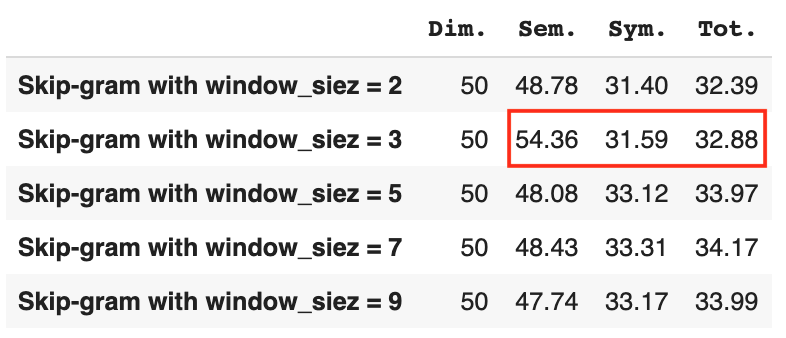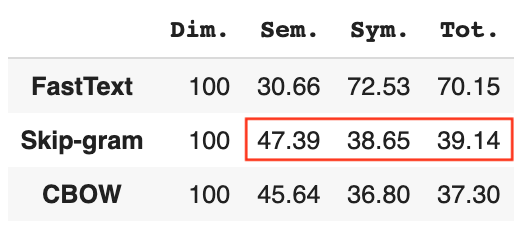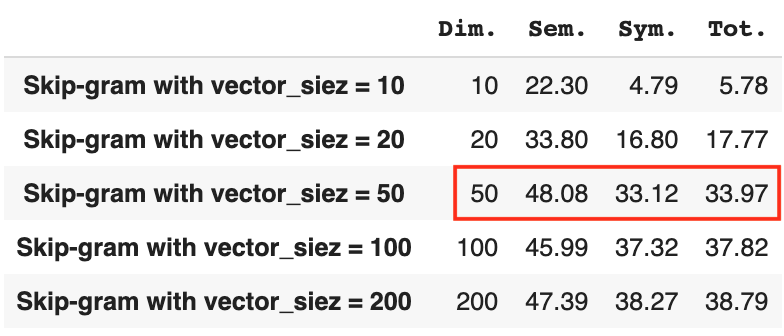

(*From the above results, it can be seen that the semantic accuracy of the Word2Vec with Skipgram model is higher, and it is more in line with the requirements of sentiment analysis. The window size is 3 and the word vector dimension of 50 is the best choice.*)

In [37]:
# Please comment your code
!git clone https://github.com/stanfordnlp/GloVe.git
import pandas as pd
import matplotlib.pyplot as pl

Cloning into 'GloVe'...
remote: Enumerating objects: 595, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 595 (delta 0), reused 1 (delta 0), pack-reused 592
Receiving objects: 100% (595/595), 222.33 KiB | 1.38 MiB/s, done.
Resolving deltas: 100% (338/338), done.


In [38]:
#code reference: https://github.com/usydnlp/COMP5046
def get_voca(file_name):

    vectors_file="/content/{}".format(file_name)
    with open(vectors_file, 'r') as f:
      vectors = {}
      for line in f.readlines()[1:]: # we only need the embedding vectors starting from the second line 
        vals = line.rstrip().split(' ')
        
        vectors[vals[0]] = [x for x in vals[1:]]

    vocab_words=list(vectors.keys())
    vocab_size = len(vocab_words)
    print("Vocab size: ",str(vocab_size))

    # create word->index and index->word converter
    vocab = {w: idx for idx, w in enumerate(vocab_words)}
    ivocab = {idx: w for idx, w in enumerate(vocab_words)}

    # create the embedding matrix of shape (vocab_size, dim)
    vector_dim = len(vectors[ivocab[0]])
    W = np.zeros((vocab_size, vector_dim))
    for word, v in vectors.items():
        if word == '<unk>':
            continue
        W[vocab[word], :] = v

    # normalize each word vector to unit length
    # Vectors are usually normalized to unit length before they are used for similarity calculation, making cosine similarity and dot-product equivalent.
    W_norm = np.zeros(W.shape)
    d = (np.sum(W ** 2, 1) ** (0.5))
    W_norm = (W.T / d).T

    return W_norm,vocab

In [39]:
#code reference: https://github.com/usydnlp/COMP5046
def evaluate_vectors(W, vocab, prefix='./eval/question-data/'):
    """Evaluate the trained word vectors on a variety of tasks"""

    filenames = [
        'capital-common-countries.txt', 'capital-world.txt', 'currency.txt',
        'city-in-state.txt', 'family.txt', 'gram1-adjective-to-adverb.txt',
        'gram2-opposite.txt', 'gram3-comparative.txt', 'gram4-superlative.txt',
        'gram5-present-participle.txt', 'gram6-nationality-adjective.txt',
        'gram7-past-tense.txt', 'gram8-plural.txt', 'gram9-plural-verbs.txt',
        ]

    # to avoid memory overflow, could be increased/decreased
    # depending on system and vocab size
    split_size = 100

    correct_sem = 0; # count correct semantic questions
    correct_syn = 0; # count correct syntactic questions
    correct_tot = 0 # count correct questions
    count_sem = 0; # count all semantic questions
    count_syn = 0; # count all syntactic questions
    count_tot = 0 # count all questions
    full_count = 0 # count all questions, including those with unknown words

    for i in range(len(filenames)):
        with open('%s/%s' % (prefix, filenames[i]), 'r') as f:
            full_data = [line.rstrip().split(' ') for line in f]
            full_count += len(full_data)
            data = [x for x in full_data if all(word in vocab for word in x)]

        if len(data) == 0:
            print("ERROR: no lines of vocab kept for %s !" % filenames[i])
            print("Example missing line:", full_data[0])
            continue

        indices = np.array([[vocab[word] for word in row] for row in data])
        ind1, ind2, ind3, ind4 = indices.T

        predictions = np.zeros((len(indices),))
        num_iter = int(np.ceil(len(indices) / float(split_size)))
        for j in range(num_iter):
            subset = np.arange(j*split_size, min((j + 1)*split_size, len(ind1)))

            pred_vec = (W[ind2[subset], :] - W[ind1[subset], :]
                +  W[ind3[subset], :])

            #cosine similarity if input W has been normalized
            dist = np.dot(W, pred_vec.T)


            for k in range(len(subset)):
                dist[ind1[subset[k]], k] = -np.Inf
                dist[ind2[subset[k]], k] = -np.Inf
                dist[ind3[subset[k]], k] = -np.Inf

            # predicted word index
            predictions[subset] = np.argmax(dist, 0).flatten()

        
        val = (ind4 == predictions) # correct predictions
        count_tot = count_tot + len(ind1)
        correct_tot = correct_tot + sum(val)
        if i < 5:
            count_sem = count_sem + len(ind1)
            correct_sem = correct_sem + sum(val)
        else:
            count_syn = count_syn + len(ind1)
            correct_syn = correct_syn + sum(val)
        
    semantic_accuracy = round(100 * correct_sem / float(count_sem), 2)
    syntactic_accuracy = round(100 * correct_syn / float(count_syn), 2)
    total_accuracy = round(100 * correct_tot / float(count_tot), 2)

    print('Semantic accuracy: %.2f%% | Syntactic accuracy: %.2f%% | Total accuracy: %.2f%%' %
    (semantic_accuracy, syntactic_accuracy, total_accuracy))

    return semantic_accuracy, syntactic_accuracy, total_accuracy


In [40]:
def get_eval_tabel(embs_txt_list,model_list,dim_list):

  eval_dict = {'Dim.':[],
             'Sem.':[],
             'Sym.':[],
             'Tot.':[],}

  for i,txt in enumerate(embs_txt_list):
    print("------------------------------------")
    print(model_list[i],'accuracy result :')
    W_norm,vocab = get_voca(txt)
    semantic_acc, syntactic_acc, total_acc = evaluate_vectors(W_norm, 
                                                            vocab, 
                                                            prefix='/content/GloVe/eval/question-data')
    #get Evaluation table
    eval_dict['Dim.'].append(dim_list[i])
    eval_dict['Sem.'].append(semantic_acc)
    eval_dict['Sym.'].append(syntactic_acc)
    eval_dict['Tot.'].append(total_acc)
    print("------------------------------------")

  tabel = pd.DataFrame(eval_dict, index=model_list)
  return eval_dict,tabel

In [94]:
embs_txt_list = ['ft_5win_100d.txt','sg_5win_100d.txt','cbow_5win_100d.txt']
model_list = ['FastText','Skip-gram','CBOW']
dim_list = [100,100,100]
_, tabel_1 = get_eval_tabel(embs_txt_list,model_list,dim_list)
tabel_1
#get Evaluation table with different embedding model

------------------------------------
FastText accuracy result :
Vocab size:  7581
Semantic accuracy: 30.66% | Syntactic accuracy: 72.53% | Total accuracy: 70.15%
------------------------------------
------------------------------------
Skip-gram accuracy result :
Vocab size:  7581
Semantic accuracy: 47.39% | Syntactic accuracy: 38.65% | Total accuracy: 39.14%
------------------------------------
------------------------------------
CBOW accuracy result :
Vocab size:  7581
Semantic accuracy: 45.64% | Syntactic accuracy: 36.80% | Total accuracy: 37.30%
------------------------------------


,Dim.,Sem.,Sym.,Tot.
FastText,100,30.66,72.53,70.15
Skip-gram,100,47.39,38.65,39.14
CBOW,100,45.64,36.80,37.30


In [42]:
emb_df_Dim_list = ['sg_5win_10d.txt',
                   'sg_5win_20d.txt',
                   'sg_5win_50d.txt',
                   'sg_5win_100d.txt',
                   'sg_5win_200d.txt']
df_Dim_model_list = ['Skip-gram with vector_siez = 10',
                     'Skip-gram with vector_siez = 20',
                     'Skip-gram with vector_siez = 50',
                     'Skip-gram with vector_siez = 100',
                     'Skip-gram with vector_siez = 200']
df_dim_list = [10,20,50,100,200]
eval_dict2, tabel_2 = get_eval_tabel(emb_df_Dim_list,df_Dim_model_list,df_dim_list)
tabel_2
#get Evaluation table of Skipgram model with different vector_siez

------------------------------------
Skip-gram with vector_siez = 10 accuracy result :
Vocab size:  7581
Semantic accuracy: 22.30% | Syntactic accuracy: 4.79% | Total accuracy: 5.78%
------------------------------------
------------------------------------
Skip-gram with vector_siez = 20 accuracy result :
Vocab size:  7581
Semantic accuracy: 33.80% | Syntactic accuracy: 16.80% | Total accuracy: 17.77%
------------------------------------
------------------------------------
Skip-gram with vector_siez = 50 accuracy result :
Vocab size:  7581
Semantic accuracy: 48.08% | Syntactic accuracy: 33.12% | Total accuracy: 33.97%
------------------------------------
------------------------------------
Skip-gram with vector_siez = 100 accuracy result :
Vocab size:  7581
Semantic accuracy: 45.99% | Syntactic accuracy: 37.32% | Total accuracy: 37.82%
------------------------------------
------------------------------------
Skip-gram with vector_siez = 200 accuracy result :
Vocab size:  7581
Semanti

,Dim.,Sem.,Sym.,Tot.
Skip-gram with vector_siez = 10,10,22.30,4.79,5.78
Skip-gram with vector_siez = 20,20,33.80,16.80,17.77
Skip-gram with vector_siez = 50,50,48.08,33.12,33.97
Skip-gram with vector_siez = 100,100,45.99,37.32,37.82
Skip-gram with vector_siez = 200,200,47.39,38.27,38.79


In [96]:
emb_df_win_list = ['sg_2win_50d.txt',
                   'sg_3win_50d.txt',
                   'sg_5win_50d.txt',
                   'sg_7win_50d.txt',
                   'sg_9win_50d.txt']
df_win_model_list = ['Skip-gram with window_siez = 2',
                     'Skip-gram with window_siez = 3',
                     'Skip-gram with window_siez = 5',
                     'Skip-gram with window_siez = 7',
                     'Skip-gram with window_siez = 9']
df_win_list = [50,50,50,50,50]
eval_dict3, tabel_3 = get_eval_tabel(emb_df_win_list,df_win_model_list,df_win_list)
tabel_3
#get Evaluation table of Skipgram model with different window_siez

------------------------------------
Skip-gram with window_siez = 2 accuracy result :
Vocab size:  7581
Semantic accuracy: 48.78% | Syntactic accuracy: 31.40% | Total accuracy: 32.39%
------------------------------------
------------------------------------
Skip-gram with window_siez = 3 accuracy result :
Vocab size:  7581
Semantic accuracy: 54.36% | Syntactic accuracy: 31.59% | Total accuracy: 32.88%
------------------------------------
------------------------------------
Skip-gram with window_siez = 5 accuracy result :
Vocab size:  7581
Semantic accuracy: 48.08% | Syntactic accuracy: 33.12% | Total accuracy: 33.97%
------------------------------------
------------------------------------
Skip-gram with window_siez = 7 accuracy result :
Vocab size:  7581
Semantic accuracy: 48.43% | Syntactic accuracy: 33.31% | Total accuracy: 34.17%
------------------------------------
------------------------------------
Skip-gram with window_siez = 9 accuracy result :
Vocab size:  7581
Semantic acc

,Dim.,Sem.,Sym.,Tot.
Skip-gram with window_siez = 2,50,48.78,31.40,32.39
Skip-gram with window_siez = 3,50,54.36,31.59,32.88
Skip-gram with window_siez = 5,50,48.08,33.12,33.97
Skip-gram with window_siez = 7,50,48.43,33.31,34.17
Skip-gram with window_siez = 9,50,47.74,33.17,33.99


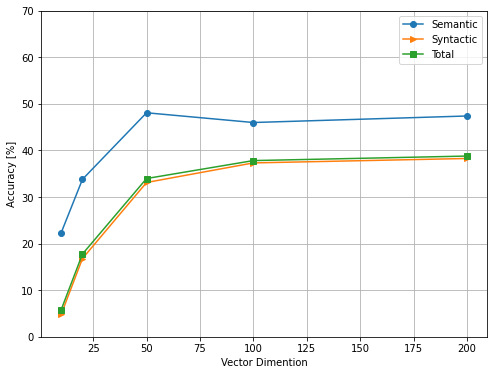

In [97]:
pl.figure(figsize=(8,6))
pl.plot(df_dim_list,eval_dict2['Sem.'],marker = "o")
pl.plot(df_dim_list,eval_dict2['Sym.'],marker = ">")
pl.plot(df_dim_list,eval_dict2['Tot.'],marker = "s")
pl.ylabel('Accuracy [%]')
pl.xlabel('Vector Dimention')
pl.legend(['Semantic','Syntactic','Total'])
pl.yticks(np.arange(0, 80, step=10))
pl.grid()
#draw Evaluation data with different embedding model

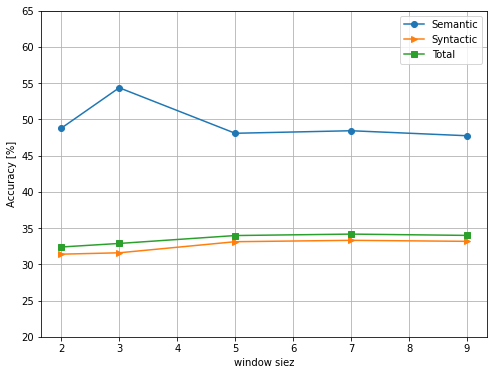

In [98]:
pl.figure(figsize=(8,6))
pl.plot([2,3,5,7,9],eval_dict3['Sem.'],marker = "o")
pl.plot([2,3,5,7,9],eval_dict3['Sym.'],marker = ">")
pl.plot([2,3,5,7,9],eval_dict3['Tot.'],marker = "s")
pl.ylabel('Accuracy [%]')
pl.xlabel('window siez')
pl.legend(['Semantic','Syntactic','Total'])
pl.yticks(np.arange(20, 70, step=5))
pl.grid()
#draw Evaluation data of Skipgram model with different window_siez

## 3.2. Performance Evaluation



(*The following results are the results of the optimal model, and the optimal model adopts the Bi-LSTM sequence model. Among them, the number of hidden layer features is 64, one layer of Lstm layer, 300 epochs are trained with a learning rate of 0.005, and the precision, recall, and f1 of the 0 and 1 labels of the test set have reached about 0.99.*)

In [46]:
# Please comment your code
model_Bilstm_005.eval()
outputs = model_Bilstm_005(torch.from_numpy(test_sent_embedding).float().to(device)) 
predicted = torch.argmax(outputs, 1)

print(classification_report(test_label_encoded, predicted.cpu().numpy(),digits=4))

              precision    recall  f1-score   support

           0     0.9909    0.9840    0.9875      1000
           1     0.9841    0.9910    0.9875      1000

    accuracy                         0.9875      2000
   macro avg     0.9875    0.9875    0.9875      2000
weighted avg     0.9875    0.9875    0.9875      2000



## 3.3. Hyperparameter Testing


(*It can be seen from the following results that the Bi-LSTM model performs better and can obtain higher F1 scores, and better results can be obtained when the learning rate is set to 0.005.*)

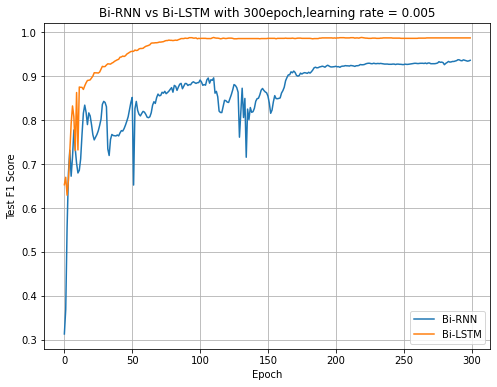

In [47]:
pl.figure(figsize=(8,6))
pl.plot(rnn_f1)
pl.plot(lstm_f1_005)
pl.xlabel('Epoch')
pl.ylabel('Test F1 Score')
pl.title('Bi-RNN vs Bi-LSTM with 300epoch,learning rate = 0.005')
pl.legend(['Bi-RNN','Bi-LSTM'],loc='best')
pl.grid()

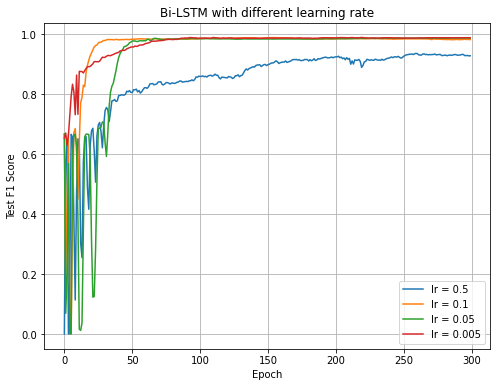

In [48]:
pl.figure(figsize=(8,6))
pl.plot(lstm_f1_5)
pl.plot(lstm_f1_1)
pl.plot(lstm_f1_05)
pl.plot(lstm_f1_005)
pl.xlabel('Epoch')
pl.ylabel('Test F1 Score')
pl.title('Bi-LSTM with different learning rate')
pl.legend(['lr = 0.5','lr = 0.1','lr = 0.05','lr = 0.005'],loc='best')
pl.grid()

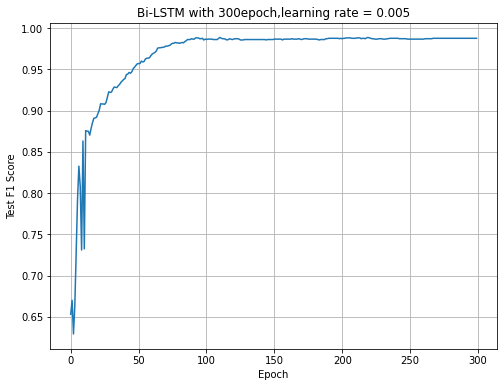

In [49]:
pl.figure(figsize=(8,6))
pl.plot(lstm_f1_005)
pl.xlabel('Epoch')
pl.ylabel('Test F1 Score')
pl.title('Bi-LSTM with 300epoch,learning rate = 0.005')
pl.grid()